## Homework 5: Deep Learning
### Jenny Zhuo

The link of my blog is https://jennyzz17.github.io/  
On the webpage, please click on the "Deep Learning" tag in the right "Tags" section to see the blog for this assignment.  
The Github repository of this Github page is https://github.com/jennyzz17/jennyzz17.github.io  
Thank you so much!

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import PIL
import pathlib
import requests
import shap
import keras.backend as K
import warnings

In [2]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from pathlib import Path
from keras.preprocessing import image
from skimage.segmentation import slic
from keras.applications.vgg16 import preprocess_input
from matplotlib.colors import LinearSegmentedColormap

In [3]:
# download the images from box to local desktop first
# then upload the images
train_dir = pathlib.Path("/Users/ahoo/Desktop/insects/train")
test_dir = pathlib.Path("/Users/ahoo/Desktop/insects/test")

In [4]:
# count the total number of pictures in the training dataset
train_image_count = len(list(train_dir.glob('*/*.jpg')))
train_image_count

1019

In [5]:
# count the total number of pictures in the test dataset
test_image_count = len(list(test_dir.glob('*/*.jpg')))
test_image_count

180

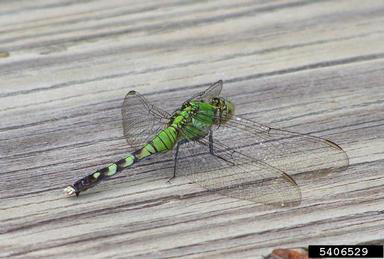

In [6]:
# showing example picture of dragon flies in the training dataset
dragon_flies_train = list(train_dir.glob('dragonflies/*'))
train_pic = PIL.Image.open(str(dragon_flies_train[0]))
train_pic

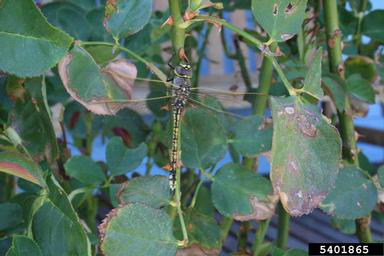

In [7]:
# showing example picture of dragon flies in the test dataset
dragon_flies_test = list(test_dir.glob('dragonflies/*'))
test_pic = PIL.Image.open(str(dragon_flies_test[0]))
test_pic

In [8]:
# load the images using keras utility
batch_size = 32
img_height = 256
img_width = 256
train_process = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size = (img_height, img_width),
    color_mode = "rgb",
    batch_size = batch_size
)
test_process = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size = (img_height, img_width),
    color_mode = "rgb",
    batch_size = batch_size
)

Found 1019 files belonging to 3 classes.
Found 180 files belonging to 3 classes.


In [9]:
train_process.take(1)

<TakeDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>

In [10]:
# print out the class names in the training dataset
class_names = train_process.class_names
class_names

['beetles', 'cockroach', 'dragonflies']

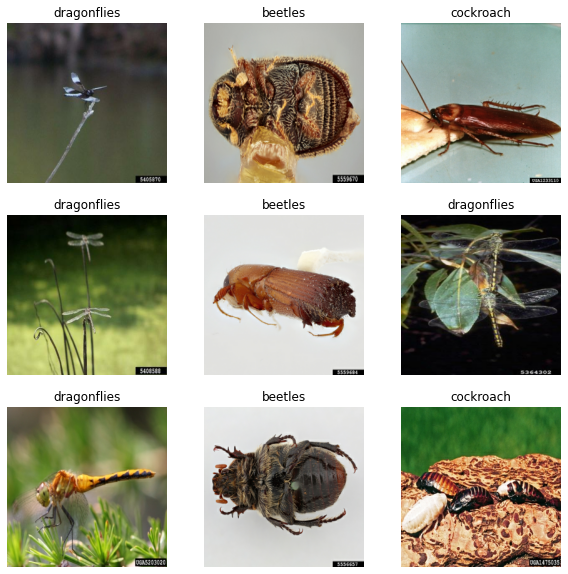

In [11]:
# visualize the training data
plt.figure(figsize = (10, 10))
for images, labels in train_process.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [12]:
for image_batch, labels_batch in train_process:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32,)


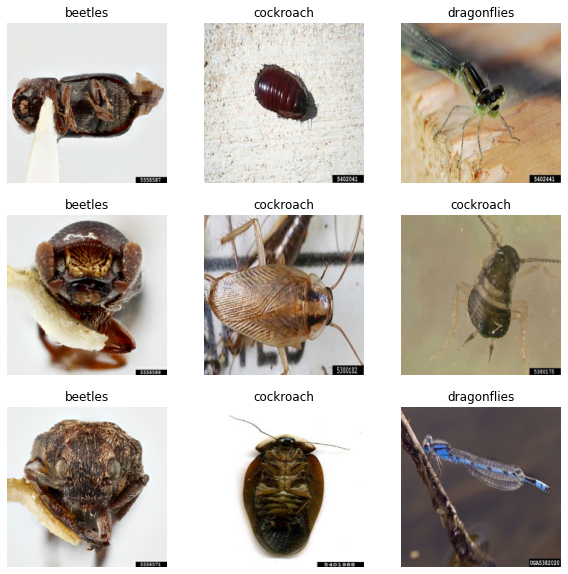

In [13]:
# visualize the test data
plt.figure(figsize = (10, 10))
for images, labels in test_process.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [14]:
for image_batch, labels_batch in test_process:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32,)


In [15]:
# configure the dataset for performance
AUTOTUNE = tf.data.AUTOTUNE

train_process = train_process.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
test_process = test_process.cache().prefetch(buffer_size = AUTOTUNE)

In [16]:
# standardize the data
normalization_layer = layers.Rescaling(1./255)
normalized_train = train_process.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_train))
first_image = image_batch[0]
# the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [17]:
# create the model
num_classes = 3
img_height = 256
img_width = 256

model = Sequential([
  layers.Rescaling(1./255, input_shape = (img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding = 'same', activation = 'relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding = 'same', activation = 'relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding = 'same', activation = 'relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation = 'relu'),
  layers.Dense(num_classes)
])

In [18]:
# compile the model
model.compile(optimizer = 'adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 64)        0

In [19]:
epochs = 10
history = model.fit(
  train_process,
  validation_data = test_process,
  epochs = epochs
)

Epoch 1/10
32/32 [==============================] - 25s 747ms/step - loss: 0.9355 - accuracy: 0.6605 - val_loss: 0.5814 - val_accuracy: 0.7667
Epoch 2/10
32/32 [==============================] - 30s 930ms/step - loss: 0.3777 - accuracy: 0.8587 - val_loss: 0.4796 - val_accuracy: 0.7833
Epoch 3/10
32/32 [==============================] - 36s 1s/step - loss: 0.2879 - accuracy: 0.8979 - val_loss: 0.3266 - val_accuracy: 0.8667
Epoch 4/10
32/32 [==============================] - 37s 1s/step - loss: 0.1953 - accuracy: 0.9225 - val_loss: 0.1918 - val_accuracy: 0.9611
Epoch 5/10
32/32 [==============================] - 40s 1s/step - loss: 0.1736 - accuracy: 0.9401 - val_loss: 0.2150 - val_accuracy: 0.9222
Epoch 6/10
32/32 [==============================] - 46s 1s/step - loss: 0.0882 - accuracy: 0.9745 - val_loss: 0.0564 - val_accuracy: 0.9889
Epoch 7/10
32/32 [==============================] - 48s 2s/step - loss: 0.0771 - accuracy: 0.9706 - val_loss: 0.0553 - val_accuracy: 0.9833
Epoch 8/10
32/

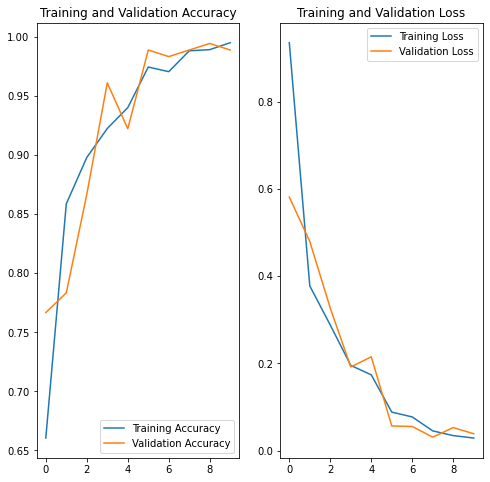

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

In [22]:
# upload a new picture of dragonfly and then check whether its classification is correct
dragon_fly = tf.keras.utils.load_img(
    "dragon_fly.png", target_size = (img_height, img_width)
)
dragon_fly_array = tf.keras.utils.img_to_array(dragon_fly)
dragon_fly_array = tf.expand_dims(dragon_fly_array, 0) # Create a batch

dragon_fly_predictions = model.predict(dragon_fly_array)
dragon_fly_score = tf.nn.softmax(dragon_fly_predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(dragon_fly_score)], 100 * np.max(dragon_fly_score))
)

This image most likely belongs to dragonflies with a 99.98 percent confidence.


In [23]:
# upload a new picture of beetle and then check whether its classification is correct
beetle = tf.keras.utils.load_img(
    "beetle.jpeg", target_size = (img_height, img_width)
)
beetle_array = tf.keras.utils.img_to_array(beetle)
beetle_array = tf.expand_dims(beetle_array, 0) # Create a batch

beetle_predictions = model.predict(beetle_array)
beetle_score = tf.nn.softmax(beetle_predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(beetle_score)], 100 * np.max(beetle_score))
)

This image most likely belongs to beetles with a 98.60 percent confidence.


In [31]:
# upload a new picture of cockroach and then check whether its classification is correct
cockroach = tf.keras.utils.load_img(
    "cockroach.jpeg", target_size = (img_height, img_width)
)
cockroach_array = tf.keras.utils.img_to_array(cockroach)
cockroach_array = tf.expand_dims(cockroach_array, 0) # Create a batch

cockroach_predictions = model.predict(cockroach_array)
cockroach_score = tf.nn.softmax(cockroach_predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(cockroach_score)], 100 * np.max(cockroach_score))
)

This image most likely belongs to cockroach with a 95.37 percent confidence.


(-0.5, 255.5, 255.5, -0.5)

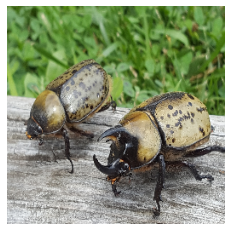

In [32]:
img = image.load_img("beetle.jpeg", target_size = (256, 256))
img_orig = image.img_to_array(img)
plt.imshow(img)
plt.axis('off')

(-0.5, 255.5, 255.5, -0.5)

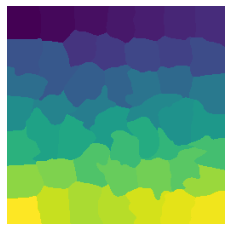

In [33]:
segments_slic = slic(img, n_segments = 50, compactness = 30, sigma = 3)
plt.imshow(segments_slic)
plt.axis('off')

In [34]:
def mask_image(zs, segmentation, image, background = None):
    if background is None:
        background = image.mean((0,1))
    out = np.zeros((zs.shape[0], image.shape[0], image.shape[1], image.shape[2]))
    for i in range(zs.shape[0]):
        out[i,:,:,:] = image
        for j in range(zs.shape[1]):
            if zs[i,j] == 0:
                out[i][segmentation == j,:] = background
    return out

def f(z):
    return model.predict(preprocess_input(mask_image(z, segments_slic, img_orig, 256)))

In [35]:
explainer = shap.KernelExplainer(f, np.zeros((1,50)))
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    shap_values = explainer.shap_values(np.ones((1,50)), nsamples = 1000)

In [36]:
feature_names = {"0": ["0", "beetles"],
                "1": ["1", "cockroach"],
                "2": ["2", "dragonflies"]}

In [37]:
preds = model.predict(preprocess_input(np.expand_dims(img_orig.copy(), axis = 0)))
top_preds = np.argsort(-preds)

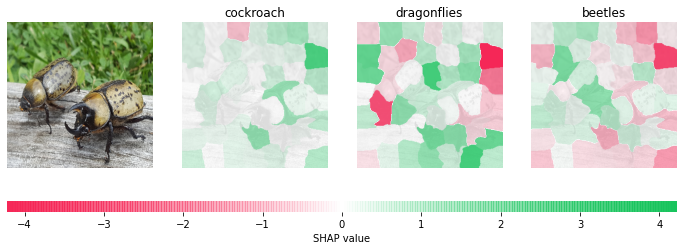

In [38]:
colors = []
for l in np.linspace(1,0,100):
    colors.append((245/255,39/255,87/255,l))
for l in np.linspace(0,1,100):
    colors.append((24/255,196/255,93/255,l))
    
cm = LinearSegmentedColormap.from_list("shap", colors)
# Visualize the explanations
def fill_segmentation(values, segmentation):
    out = np.zeros(segmentation.shape)
    for i in range(len(values)):
        out[segmentation == i] = values[i]
    return out
# plot our explanations
fig, axes = plt.subplots(nrows = 1, ncols = 4, figsize = (12,4))
inds = top_preds[0]
axes[0].imshow(img)
axes[0].axis('off')
max_val = np.max([np.max(np.abs(shap_values[i][:,:-1])) for i in range(len(shap_values))])
for i in range(3):
    m = fill_segmentation(shap_values[inds[i]][0], segments_slic)
    axes[i+1].set_title(feature_names[str(inds[i])][1])
    axes[i+1].imshow(img.convert('LA'), alpha = 0.15)
    im = axes[i+1].imshow(m, cmap = cm, vmin = -max_val, vmax = max_val)
    axes[i+1].axis('off')
cb = fig.colorbar(im, ax = axes.ravel().tolist(), label = "SHAP value", orientation = "horizontal", aspect = 60)
cb.outline.set_visible(False)
plt.show()

In [39]:
model.save_weights('model_saved.h5')